# Clustering Medium article titles

We use a collection of article titles from Medium to carry out doc2vec transformation of the titles, then cluster them in the vector space.

The dataset is from:
https://www.kaggle.com/nulldata/medium-post-titles?select=medium_post_titles.csv

To run this notebook, you will need to dowload the dataset the put it in a folder called 'kaggle_datasets'.

In [1]:
import numpy as np
import pandas as pd

import re
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import string 

from sklearn.manifold import TSNE
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

/home/katinka/.pyenv/versions/3.8.0/envs/text_cluster_env/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
#nltk.download('punkt')

## Data Exploration

In [20]:
# Read in the dataset
df = pd.read_csv('kaggle_datasets/medium_post_titles.csv')

In [21]:
df.head(3)

category                                              title  \
0          work  "21 Conversations" - A fun (and easy) game for...   
1  spirituality                       "Biblical Porn" at Mars Hill   
2       lgbtqia                  "CISGENDER?! Is That A Disease?!"   

                                            subtitle  subtitle_truncated_flag  
0  A (new?) Icebreaker game to get your team to s...                    False  
1  Author and UW lecturer Jessica Johnson talks a...                    False  
2  Or, a primer in gender vocabulary for the curi...                    False

Let's have a look at the categories

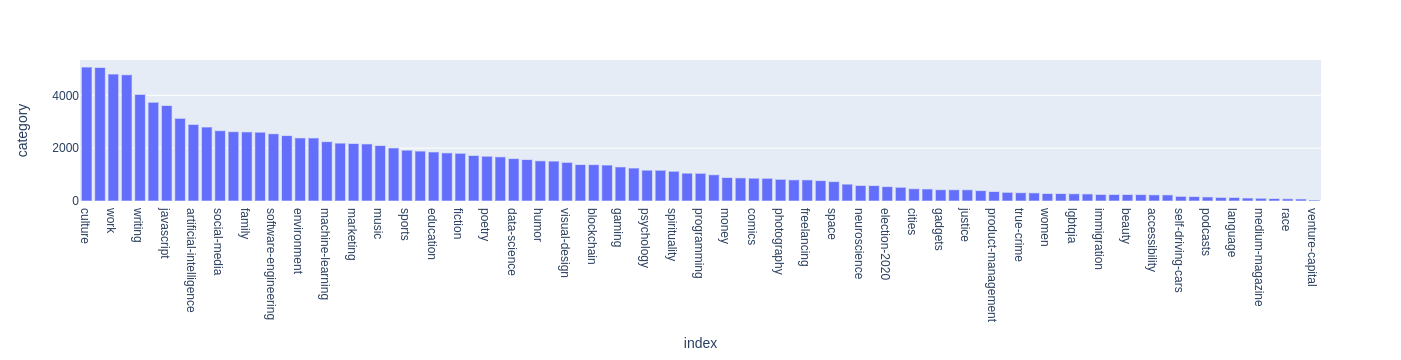

In [22]:
fig = px.bar(df['category'].value_counts().reset_index(), x='index', y='category')
fig.show()

We will focus on the top 5 categories

In [24]:
# Select top five categories
cat_df = df['category'].value_counts().reset_index().head(5).rename(columns={'index':'category', 'category':'count'})
cat_list = cat_df['category'].tolist()

df = df[df['category'].isin(cat_list)]

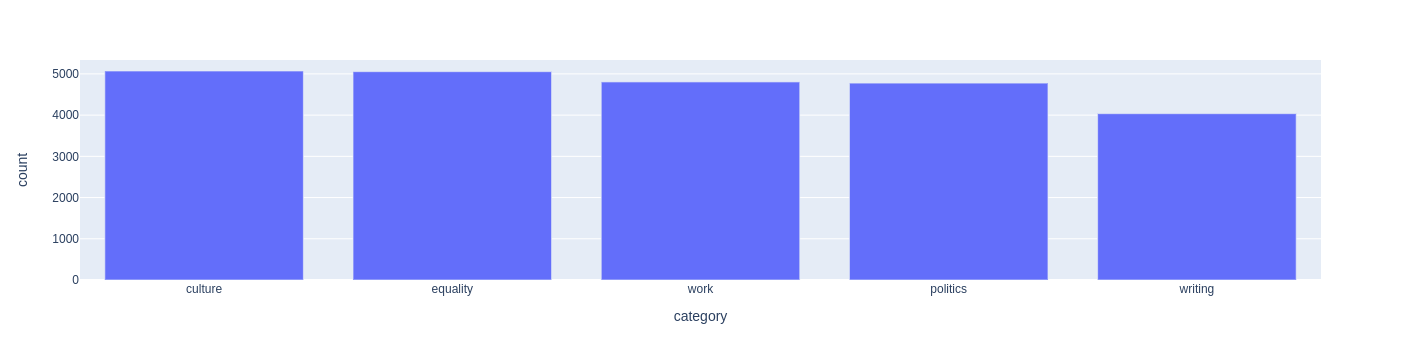

In [25]:
fig = px.bar(cat_df, x='category', y='count')
fig.show()

In [26]:
len(df)

23741

In [27]:
df['category'].nunique()

5

## Doc2Vec conversion

First, we need to clean the data and convert them into tagged documents.

In [28]:
def clean_punc(row):
    """
    Remove punctuations.
    """
    # Remove puntuations
    text = ''.join([c for c in str(row) if c not in string.punctuation])
    # Define the pattern 
    pat = r'[^a-zA-z0-9.,!?/:;\"\'|\r\s]\n' 
    word = re.sub(pat, '', text)
    # Remove new line
    cleaned = re.sub('\n','',word)
    return str(cleaned)

In [29]:
# Create list of titles
data = df['title'].tolist()

# Remove Special characters
data = [clean_punc(item) for item in data]

data[:5]

['21 Conversations  A fun and easy game for teams to get to know each other',
 'Call me Nat Love Black Cowboys and the Frontiers of American Freedom',
 'Diss vs Piss The Blue Wave and Yellow Trickle in Californias Central Valley',
 'Happily Ever After Fairy Tales for Every Child or the Underrated HBO Show That Tried to Tackle…',
 'Killing Eve and Women Who Love Murder']

In [30]:
# Tag the data
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(data)]
tagged_data[:2]

[TaggedDocument(words=['21', 'conversations', 'a', 'fun', 'and', 'easy', 'game', 'for', 'teams', 'to', 'get', 'to', 'know', 'each', 'other'], tags=['0']),
 TaggedDocument(words=['call', 'me', 'nat', 'love', 'black', 'cowboys', 'and', 'the', 'frontiers', 'of', 'american', 'freedom'], tags=['1'])]

In [31]:
# Train doc2vec model
vec_size = 100
alpha = 0.025
nr_epochs = 100

model = Doc2Vec(vector_size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                workers=5,
                dm=1)
  
model.build_vocab(tagged_data)


model.train(tagged_data,
            total_examples=model.corpus_count,
            epochs=nr_epochs)

model.save("d2v_sm.model")
print("Model Saved")

Model Saved


## Clustering based on doc2vec vectors

In [32]:
# Load the model
model = Doc2Vec.load("d2v_sm.model")

In [33]:
# Get the vectors
data_vects = model.dv.vectors

In [34]:
# Train t-SNE model for clustering
tsne = TSNE(n_components=2, 
            verbose=2,
            perplexity=30, 
            n_iter=2000, 
            init='pca')

tsne_vectors = tsne.fit_transform(data_vects)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 23741 samples in 0.002s...
[t-SNE] Computed neighbors for 23741 samples in 17.834s...
[t-SNE] Computed conditional probabilities for sample 1000 / 23741
[t-SNE] Computed conditional probabilities for sample 2000 / 23741
[t-SNE] Computed conditional probabilities for sample 3000 / 23741
[t-SNE] Computed conditional probabilities for sample 4000 / 23741
[t-SNE] Computed conditional probabilities for sample 5000 / 23741
[t-SNE] Computed conditional probabilities for sample 6000 / 23741
[t-SNE] Computed conditional probabilities for sample 7000 / 23741
[t-SNE] Computed conditional probabilities for sample 8000 / 23741
[t-SNE] Computed conditional probabilities for sample 9000 / 23741
[t-SNE] Computed conditional probabilities for sample 10000 / 23741
[t-SNE] Computed conditional probabilities for sample 11000 / 23741
[t-SNE] Computed conditional probabilities for sample 12000 / 23741
[t-SNE] Computed conditional probabilities for sa

Next, we create the t-SNE dataframe, also adding category as a variable.

In [36]:
# Create t-SNE dataframe
tsne_df = pd.DataFrame(
    tsne_vectors,
    index=df['title'].tolist(),
    columns=['x_coord', 'y_coord']
    )

tsne_df['category'] = df['category'].tolist()

tsne_df = tsne_df.reset_index()

Visualise the results, color-coded by category.

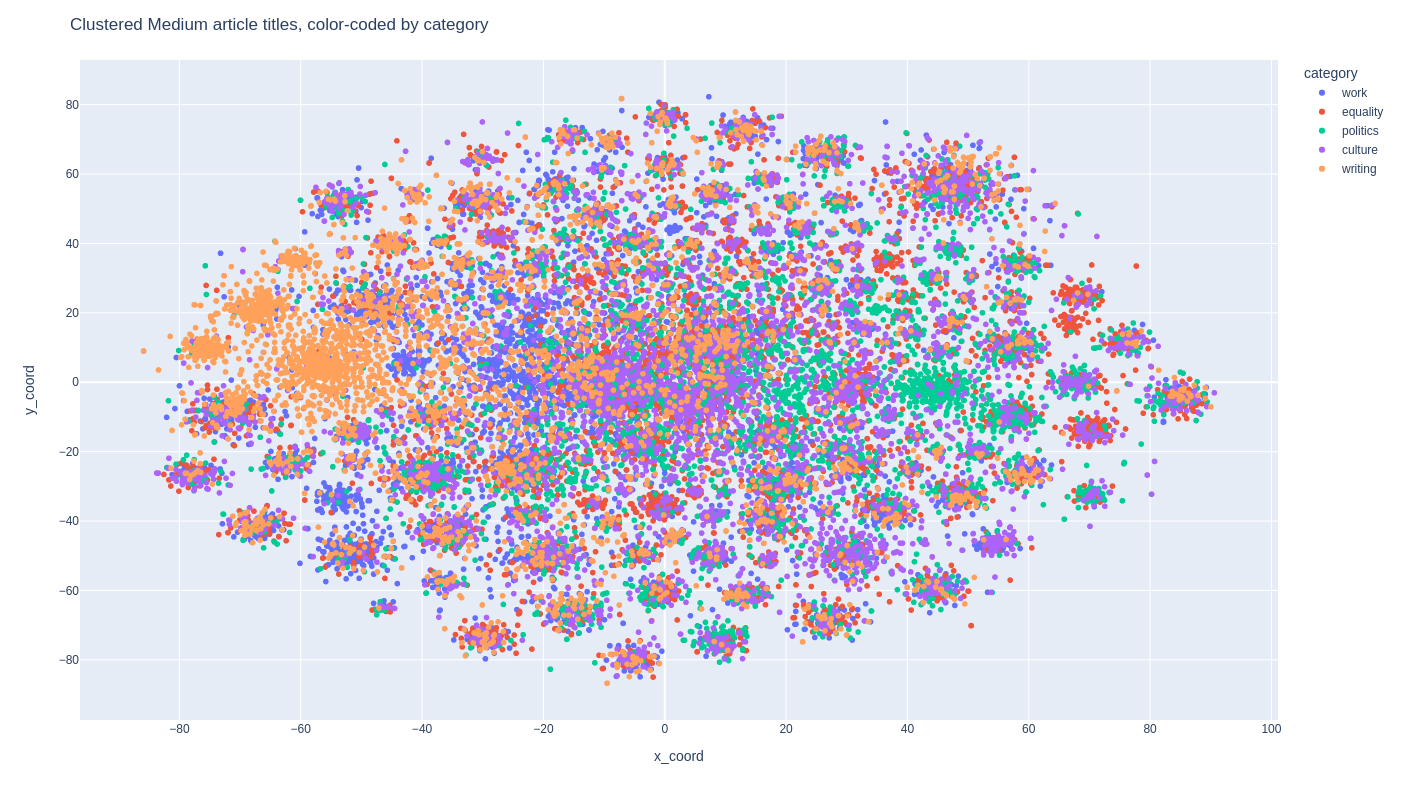

In [37]:
# x and y given as DataFrame columns
fig = px.scatter(tsne_df, 
                 x="x_coord", 
                 y="y_coord",
                 hover_data=['index', 'category'],
                 color='category'
                )
fig.update_layout(width=1000,
                  height=800, 
                  title='Clustered Medium article titles, color-coded by category'
                 )
fig.show()